# Using the TDCOSMO likelihood with Cobaya

Author: Natalie B. Hogg

## Installation

This notebook assumes that you have installed Cobaya as described here: https://cobaya.readthedocs.io/en/latest/installation.html, along with hierArc and lenstronomy. You also need to clone the `tdcosmo_ext` repository to your machine and change the paths in the settings below to match where you have saved it.

## Sampling

Cobaya takes its settings either as Python dictionaries or in yaml format. Here are the yaml settings to do a very quick test run. Most of the parameters are kept fixed to arbitrary values.

In the `likelihood` block we call the TDCOSMO external likelihood, and we also exploit the external likelihood capability of Cobaya to impose the Pantheon prior on $\Omega_{\rm m}$, as done in the original TDCOSMO analysis. We have to set the prior in this way because in the Cobaya framework, $\Omega_{\rm m}$ is a derived parameter and therefore not directly sampled. This means we can't set a prior on it in the `params` block as done with e.g. $H_0$.

In [1]:
info_yaml = r"""
likelihood:
    tdcosmo.tdcosmo.TDCOSMO:
      python_path: /home/natalie/Projects/slide/tdcosmo_ext/
      tdcosmo_lenses: data/tdcosmo7_likelihood_processed.pkl
    prior_omegam:  
      external: "lambda _self: stats.norm.pdf(_self.provider.get_param('omegam'), loc=0.298, scale=0.022)"
      requires: omegam

theory:
    camb:
        stop_at_error: True
        extra_args:
            lens_potential_accuracy: 1

params:
  lambda_mst: 1.0
  lambda_mst_sigma: 0.01
  alpha_lambda: 0.0
  a_ani: 0.2
  a_ani_sigma: 0.05
  H0:
    prior:
        min: 0
        max: 150
    ref:
        dist: norm
        loc: 72
        scale: 2
    proposal: 0.1
    latex: H_0
  omegam:
    latex: \Omega_{\rm m}  
  w: -1.0
  wa: 0.0
  omegak: 0.0
  mnu: 0.06
  ombh2: 0.04
  
sampler:
    mcmc:
      Rminus1_stop: 1.0

output: chains/tdcosmo_tiny_omp
force: True
"""

This will use the TDCOSMO likelihood with the 7 TDCOSMO lenses (the SLACS lenses can also be added following the same pattern as the TDCOSMO data in the above yaml example) and use camb as the theory code to calculate angular diameter distances. However, any theory code implemented in Cobaya can be used. The basic MCMC sampler in Cobaya is used, but again, any available sampler in Cobaya can be used. The sampling is requested to stop when the Gelman--Rubin criterion gets below 1.0. This is not sufficient for convergence, but is ok for a quick check.

The chains are written to the path given, and `force: True` overwrites previous products with the same path and name.

In [2]:
# import the yaml package
from cobaya.yaml import yaml_load

# load the info
info = yaml_load(info_yaml)

In [3]:
# import the run package
from cobaya.run import run

# run the sampler with the above info
updated_info, sampler = run(info)

[output] Output to be read-from/written-into folder 'chains', with prefix 'tdcosmo_tiny_omp'
[output] Found existing info files with the requested output prefix: 'chains/tdcosmo_tiny_omp'
[output] Will delete previous products ('force' was requested).
[camb] `camb` module loaded successfully from /home/natalie/Projects/slide/cobaya_packages/code/CAMB/camb
Using TDCOSMO lenses
SLACS SDSS lenses not being used
SLACS IFU lenses not being used
[prior_omegam] Initialized external likelihood.
[mcmc] Getting initial point... (this may take a few seconds)
[model] Measuring speeds... (this may take a few seconds)
[model] Setting measured speeds (per sec): {tdcosmo.tdcosmo.TDCOSMO: 0.905, prior_omegam: 2460.0, camb.transfers: 16.6, camb: 2020.0}
[mcmc] Initial point: H0:71.89456
[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).
[mcmc] Sampling!
[mcmc] Progress @ 2023-09-11 11:17:07 : 1 steps taken, and

## Results

[root] *WARNING* outlier fraction 0.084375 


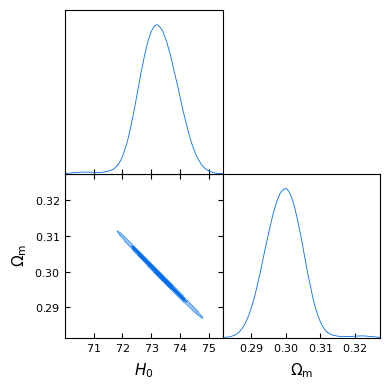

In [4]:
# import getdist to analyse the chain
from getdist.mcsamples import MCSamplesFromCobaya
import getdist.plots as gdplt
%matplotlib inline

# create the MCSamples object
gd_sample = MCSamplesFromCobaya(updated_info, sampler.products()["sample"])

# get the subplot plotter
gdplot = gdplt.getSubplotPlotter()

# choose some parameters to plot
gdplot.triangle_plot(gd_sample, ['H0', 'omegam'], filled=True)

We can see that the sampler runs and obtains reasonable contours, but convergence is evidently not reached, with some long tails in the posteriors. The sampling should be repeated with all the nuisance parameters sampled, and a smaller R-1 in place.

If you want to run from the terminal rather than a notebook/script, simply copy the yaml information into a `<filename>.yaml` file and run with 

`$ cobaya-run <filename>.yaml`. 

This method should also be used for submitting batch jobs on a cluster.